In [2]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
import pickle

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [3]:
# I want to use neural timestamps to interp from behavior, then assign behaviors to bins

In [4]:
X_all_neural_z_vox_t = np.load("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_z_vox_t_correct.npy")
X_all_neural_timestamps_z_t = np.load("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_timestamps_z_t.npy")

In [5]:
X_all_neural_z_vox_t.shape, X_all_neural_timestamps_z_t.shape

((49, 2000, 30456), (30456, 49))

In [8]:
X_std = np.std(X_all_neural_z_vox_t,axis=2)
X_std.shape

(49, 2000)

In [16]:
X_all_neural_z_vox_t /= X_std[...,np.newaxis]

In [9]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/master_X.npy"
X = np.load(file)
X.shape

(49, 9, 2000, 3384)

In [10]:
fwd = X[:,:,250,:]
rot_pos = X[:,:,750,:]
rot_neg = X[:,:,1250,:]
del X

In [11]:
fwd = np.reshape(fwd,(49,9*3384))
rot_pos = np.reshape(rot_pos,(49,9*3384))
rot_neg = np.reshape(rot_neg,(49,9*3384))

In [12]:
X = None

In [1]:
fwd.shape

NameError: name 'fwd' is not defined

In [14]:
import gc
gc.collect()

7

In [15]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 24.39GB


In [12]:
# because we need to do the correction for orginal z-slice, we need to loop over clusters
# so we first want to make a behavior matrix with [fly,z,behavior,time]
# we technically already have this as master_X

In [13]:
# this is too complicated for this anaylsis for now. lets do the easy way
fwd.shape, rot_pos.shape, rot_neg.shape

((49, 30456), (49, 30456), (49, 30456))

In [14]:
X_all_neural_z_vox_t.shape

(49, 2000, 30456)

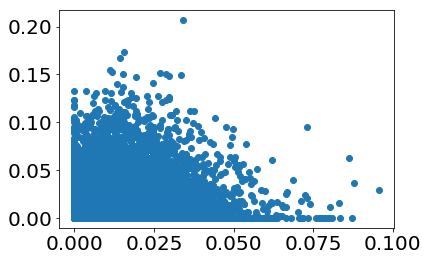

In [41]:
plt.plot(fwd[20,:], rot_pos[20,:],'o')

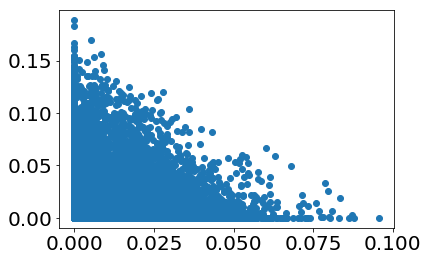

In [39]:
plt.plot(fwd[20,:], rot_neg[20,:],'o')

In [46]:
np.where(rot_pos > .075)[0].shape

(18356,)

In [49]:
np.where(rot_pos > .075)[0]

array([ 0,  0,  0, ..., 48, 48, 48])

In [47]:
np.where(rot_pos > .075)[1].shape

(18356,)

In [50]:
X_all_neural_z_vox_t[np.where(rot_pos > .075)[0], :, np.where(rot_pos > .075)[1]].shape

(18356, 2000)

In [10]:
z=20
np.where(fwd[z,:] > .03)[0].shape

(1263,)

In [16]:
np.where((fwd[z,:] > .01) &
         (fwd[z,:] <.03) &
         (rot_pos[z,:] < .01) & 
         (rot_neg[z,:] < .01))[0].shape

(1216,)

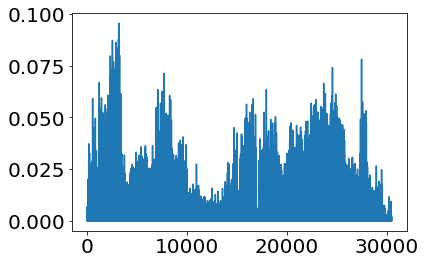

In [119]:
plt.plot(fwd[20,:])

In [17]:
mean_signals = {}
z=20

signals_fwd = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where(fwd[z,:] > .03)][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd'] = np.asarray(signals_fwd)

signals_rot_pos = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where(rot_pos[z,:] > .05)][0,:,:],axis=0)
    signals_rot_pos.append(signal)
mean_signals['rot_pos'] = np.asarray(signals_rot_pos)

signals_rot_neg = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where(rot_neg[z,:] > .05)][0,:,:],axis=0)
    signals_rot_neg.append(signal)
mean_signals['rot_neg'] = np.asarray(signals_rot_neg)

signals_fwd = []
for z in range(49):
    idx = np.where((fwd[z,:] > .01) & (fwd[z,:] <.03) & (rot_pos[z,:] < .01) & (rot_neg[z,:] < .01))
    signal = np.mean(X_all_neural_z_vox_t[z,:,idx][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd_slow'] = np.asarray(signals_fwd)

In [18]:
signals_fwd = []
for z in range(49):
    idx = np.where((fwd[z,:] > .03) & (rot_pos[z,:] < .01) & (rot_neg[z,:] < .01))
    signal = np.mean(X_all_neural_z_vox_t[z,:,idx][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd_fast'] = np.asarray(signals_fwd)

signals_fwd = []
for z in range(49):
    idx = np.where((fwd[z,:] > -.01) & (fwd[z,:] <.01) & (rot_pos[z,:] < .01) & (rot_neg[z,:] < .01))
    signal = np.mean(X_all_neural_z_vox_t[z,:,idx][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['stopped'] = np.asarray(signals_fwd)

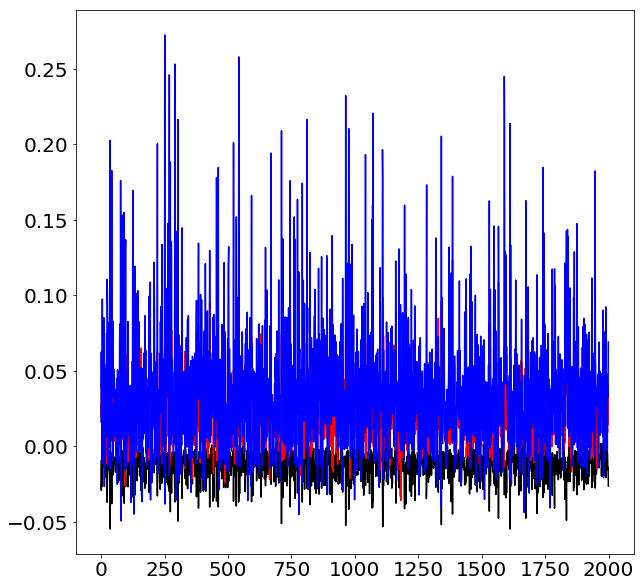

In [70]:
plt.figure(figsize=(10,10))
plt.plot(mean_signals['stopped'][20,:],color='k')
plt.plot(mean_signals['fwd_slow'][20,:],color='r')
plt.plot(mean_signals['fwd_fast'][20,:],color='b')

In [19]:
#####################
### Make Clusters ###
#####################
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [20]:
all_colored_by_betas = {}
for beh in ['fwd', 'rot_pos', 'rot_neg', 'fwd_slow', 'fwd_fast', 'stopped']:
    all_colored_by_betas[beh] = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = mean_signals[beh][z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas[beh].append(colored_by_betas)
    all_colored_by_betas[beh] = np.asarray(all_colored_by_betas[beh])
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],0,1)
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],1,2)

In [21]:
################
### JFRC2018 ###
################

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)

### Down-sample jfrc to 2um isotropic
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)
#fixed_lowres = ants.resample_image(fixed,(156, 73, 46),use_voxels=True) #almost exactly 4um, but even width

In [22]:
#################
### Luke Mean ###
#################

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)

### down-sample luke_mean to func res
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [23]:
############
### WARP ###
############

out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [24]:
res_LUKE = (2.6076, 2.6154, 5.3125)
maps_voxel_res = {}
for beh in ['fwd', 'rot_pos', 'rot_neg', 'fwd_slow', 'fwd_fast', 'stopped']:
    moving = ants.from_numpy(all_colored_by_betas[beh][:,:,::-1])
    moving.set_spacing(res_LUKE)
    maps_voxel_res[beh] = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0])

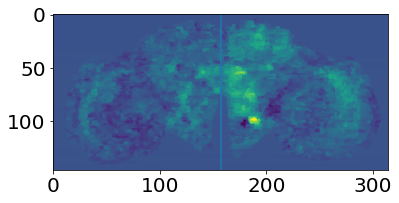

In [21]:
plt.imshow(maps_voxel_res['rot_neg'][:,:,50].T)
plt.axvline(314/2)

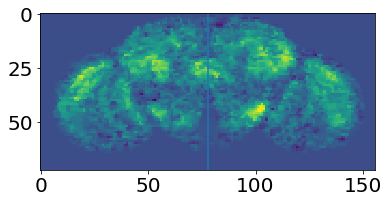

In [153]:
plt.imshow(maps_voxel_res['fwd_slow'][:,:,30].T)
plt.axvline(156/2)

In [61]:
maps_voxel_res['fwd_slow'].shape

(314, 146, 91)

In [25]:
diff_map = maps_voxel_res['fwd_slow']-maps_voxel_res['stopped']

In [85]:
diff_map = maps_voxel_res['stopped']-maps_voxel_res['fwd_slow']

In [81]:
diff_map = maps_voxel_res['fwd_slow']-maps_voxel_res['fwd_fast']

In [79]:
diff_map = maps_voxel_res['stopped']-maps_voxel_res['fwd_fast']

In [43]:
diff_map1 = maps_voxel_res['fwd_slow']-maps_voxel_res['fwd']
diff_map2 = (maps_voxel_res['fwd_slow']-maps_voxel_res['fwd'])
diff_map2 = diff_map2[::-1,:,:]
diff_map = (diff_map1+diff_map2)/2

In [36]:
diff_map1 = maps_voxel_res['fwd_slow']-maps_voxel_res['rot_pos']
diff_map2 = (maps_voxel_res['fwd_slow']-maps_voxel_res['rot_neg'])
diff_map2 = diff_map2[::-1,:,:]
diff_map = (diff_map1+diff_map2)/2

In [37]:
corr = diff_map.numpy().copy() #diff_map.numpy().copy()

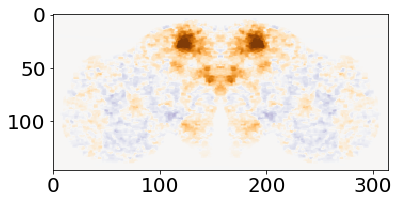

In [46]:
plt.imshow(diff_map2[:,:,50].T,vmin=-.1,vmax=.1,cmap='PuOr')

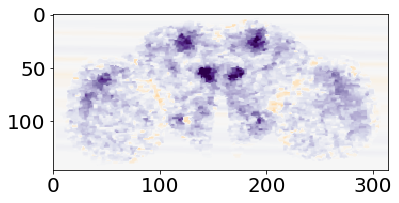

In [48]:
plt.imshow(diff_map[:,:,50].T,vmin=-.1,vmax=.1,cmap='PuOr')

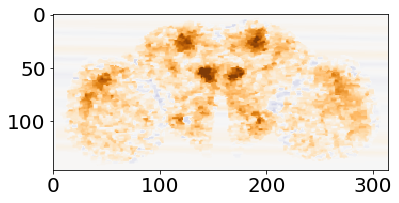

In [46]:
plt.imshow(diff_map[:,:,50].T,vmin=-.1,vmax=.1,cmap='PuOr')

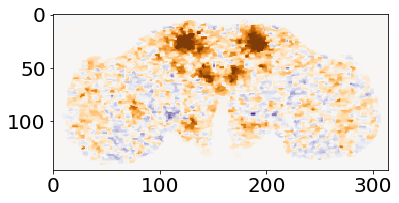

In [82]:
plt.imshow(diff_map[:,:,50].T,vmin=-.1,vmax=.1,cmap='PuOr')

In [ ]:
plt.imshow(diff_map[:,:,50].T,vmin=-.1,vmax=.1,cmap='PuOr')

In [27]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
#atlas = ants.resample_image(atlas,(256,128,49),use_voxels=True)

(-0.5, 313.5, 145.5, -0.5)

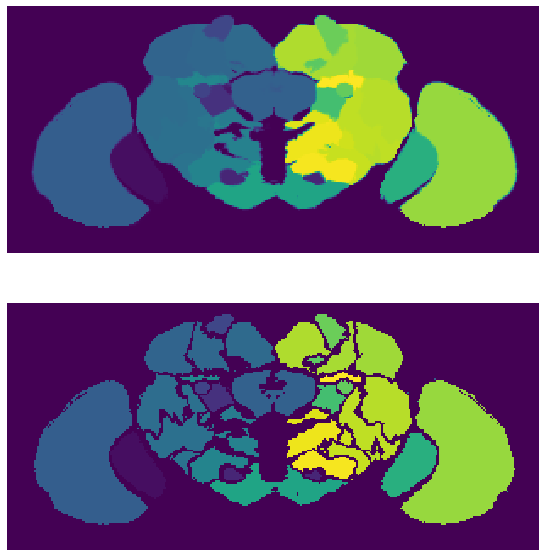

In [28]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [29]:
####################################
### FOR SINGLE MAP (ie, not RGB) ###
####################################

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # use this for plotting clusters
#         # temporal
#         masked_roi = mask_dilated*np.nan_to_num(to_plot_new)#*temporal_map #CORR
#         #masked_roi = mask_dilated*np.nan_to_num(corr)#*temporal_map #CORR

#         masked_roi_flat = np.max(masked_roi,axis=2)
#         roi_data.append(masked_roi_flat)
        #print(np.sum())
        
        #PCA or any diverging (Turn off if above is on) <---------------
        masked_roi = mask_dilated*np.nan_to_num(corr)
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        masked_roi_flat = maxs
        roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
        
    #for plotting clusters
#     roi_datas = np.max(np.asarray(roi_data),axis=0)
#     data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA (Turn off if above is on) <---------------
    roi_data = np.asarray(roi_data)
    maxs = np.max(roi_data,axis=0)
    mins = np.min(roi_data,axis=0)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1 #changed from 1 to -1 so can use set_under to pick specific color
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] += to_plot #made this +=
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [30]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [40]:
diff_map

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [38]:
# canvi = []
# for n in tqdm(range(1,5)):
#     cN = np.where(np.asarray(cluster_reassignment)==n)[0]+1
#     corr = to_plot.copy()
#     corr[np.where((to_plot<cN[0]) | (to_plot>cN[-1]))]=np.nan

#corr = diff_map.numpy().copy()
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)

canvas[np.where(canvas==0)] = np.nan

# plt.figure(figsize=(10,10))
# plt.imshow(canvas[150:,:],cmap='PiYG',vmin=-.10,vmax=.10)
# plt.axis('off')

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# #plt.savefig(fname,dpi=300,bbox_inches='tight')

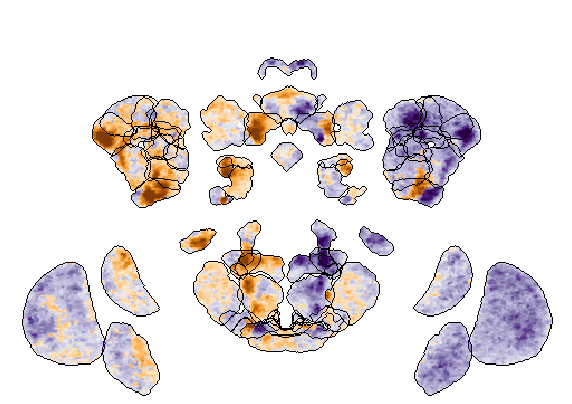

In [40]:
borders = np.zeros((500,500,4))
borders[np.where(canvas==1)] = 0
borders[np.where(canvas==1)[0],np.where(canvas==1)[1],3] = 1

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap='PuOr',vmin=-.2,vmax=.2) #.15
#plt.colorbar()
plt.axis('off')
plt.imshow(borders[150:,:])

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [89]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['w', '#08FF25'])
colors1 = cmap(np.linspace(0., 1, 128))

cmap = LinearSegmentedColormap.from_list('mycmap', ['w', '#0C4F14'])
colors2 = cmap(np.linspace(0., 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1[::-1], colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [32]:
c_name = 'BrBG'#'YlOrRd'
data = colorbrewer[c_name]['8']
extracted = []
for i in range(len(data)):
    numstr = re.findall(r'\d+', colorbrewer[c_name]['8'][i])
    numstring = [int(j)/255 for j in numstr]
    extracted.append(numstring)
testmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', extracted)

In [31]:
#https://colorbrewer2.org/
import re
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


colorbrewer = { 
"Spectral":  {"3": ["rgb(252,141,89)", "rgb(255,255,191)", "rgb(153,213,148)"], "4": ["rgb(215,25,28)", "rgb(253,174,97)", "rgb(171,221,164)", "rgb(43,131,186)"], "5": ["rgb(215,25,28)", "rgb(253,174,97)", "rgb(255,255,191)", "rgb(171,221,164)", "rgb(43,131,186)"], "6": ["rgb(213,62,79)", "rgb(252,141,89)", "rgb(254,224,139)", "rgb(230,245,152)", "rgb(153,213,148)", "rgb(50,136,189)"], "7": ["rgb(213,62,79)", "rgb(252,141,89)", "rgb(254,224,139)", "rgb(255,255,191)", "rgb(230,245,152)", "rgb(153,213,148)", "rgb(50,136,189)"], "8": ["rgb(213,62,79)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(230,245,152)", "rgb(171,221,164)", "rgb(102,194,165)", "rgb(50,136,189)"], "9": ["rgb(213,62,79)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(255,255,191)", "rgb(230,245,152)", "rgb(171,221,164)", "rgb(102,194,165)", "rgb(50,136,189)"], "10": ["rgb(158,1,66)", "rgb(213,62,79)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(230,245,152)", "rgb(171,221,164)", "rgb(102,194,165)", "rgb(50,136,189)", "rgb(94,79,162)"], "11": ["rgb(158,1,66)", "rgb(213,62,79)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(255,255,191)", "rgb(230,245,152)", "rgb(171,221,164)", "rgb(102,194,165)", "rgb(50,136,189)", "rgb(94,79,162)"], "type": "div"} ,
"RdYlGn":  {"3": ["rgb(252,141,89)", "rgb(255,255,191)", "rgb(145,207,96)"], "4": ["rgb(215,25,28)", "rgb(253,174,97)", "rgb(166,217,106)", "rgb(26,150,65)"], "5": ["rgb(215,25,28)", "rgb(253,174,97)", "rgb(255,255,191)", "rgb(166,217,106)", "rgb(26,150,65)"], "6": ["rgb(215,48,39)", "rgb(252,141,89)", "rgb(254,224,139)", "rgb(217,239,139)", "rgb(145,207,96)", "rgb(26,152,80)"], "7": ["rgb(215,48,39)", "rgb(252,141,89)", "rgb(254,224,139)", "rgb(255,255,191)", "rgb(217,239,139)", "rgb(145,207,96)", "rgb(26,152,80)"], "8": ["rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(217,239,139)", "rgb(166,217,106)", "rgb(102,189,99)", "rgb(26,152,80)"], "9": ["rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(255,255,191)", "rgb(217,239,139)", "rgb(166,217,106)", "rgb(102,189,99)", "rgb(26,152,80)"], "10": ["rgb(165,0,38)", "rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(217,239,139)", "rgb(166,217,106)", "rgb(102,189,99)", "rgb(26,152,80)", "rgb(0,104,55)"], "11": ["rgb(165,0,38)", "rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,139)", "rgb(255,255,191)", "rgb(217,239,139)", "rgb(166,217,106)", "rgb(102,189,99)", "rgb(26,152,80)", "rgb(0,104,55)"], "type": "div"} ,
"RdBu":  {"3": ["rgb(239,138,98)", "rgb(247,247,247)", "rgb(103,169,207)"], "4": ["rgb(202,0,32)", "rgb(244,165,130)", "rgb(146,197,222)", "rgb(5,113,176)"], "5": ["rgb(202,0,32)", "rgb(244,165,130)", "rgb(247,247,247)", "rgb(146,197,222)", "rgb(5,113,176)"], "6": ["rgb(178,24,43)", "rgb(239,138,98)", "rgb(253,219,199)", "rgb(209,229,240)", "rgb(103,169,207)", "rgb(33,102,172)"], "7": ["rgb(178,24,43)", "rgb(239,138,98)", "rgb(253,219,199)", "rgb(247,247,247)", "rgb(209,229,240)", "rgb(103,169,207)", "rgb(33,102,172)"], "8": ["rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(209,229,240)", "rgb(146,197,222)", "rgb(67,147,195)", "rgb(33,102,172)"], "9": ["rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(247,247,247)", "rgb(209,229,240)", "rgb(146,197,222)", "rgb(67,147,195)", "rgb(33,102,172)"], "10": ["rgb(103,0,31)", "rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(209,229,240)", "rgb(146,197,222)", "rgb(67,147,195)", "rgb(33,102,172)", "rgb(5,48,97)"], "11": ["rgb(103,0,31)", "rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(247,247,247)", "rgb(209,229,240)", "rgb(146,197,222)", "rgb(67,147,195)", "rgb(33,102,172)", "rgb(5,48,97)"], "type": "div"} ,
"PiYG":  {"3": ["rgb(233,163,201)", "rgb(247,247,247)", "rgb(161,215,106)"], "4": ["rgb(208,28,139)", "rgb(241,182,218)", "rgb(184,225,134)", "rgb(77,172,38)"], "5": ["rgb(208,28,139)", "rgb(241,182,218)", "rgb(247,247,247)", "rgb(184,225,134)", "rgb(77,172,38)"], "6": ["rgb(197,27,125)", "rgb(233,163,201)", "rgb(253,224,239)", "rgb(230,245,208)", "rgb(161,215,106)", "rgb(77,146,33)"], "7": ["rgb(197,27,125)", "rgb(233,163,201)", "rgb(253,224,239)", "rgb(247,247,247)", "rgb(230,245,208)", "rgb(161,215,106)", "rgb(77,146,33)"], "8": ["rgb(197,27,125)", "rgb(222,119,174)", "rgb(241,182,218)", "rgb(253,224,239)", "rgb(230,245,208)", "rgb(184,225,134)", "rgb(127,188,65)", "rgb(77,146,33)"], "9": ["rgb(197,27,125)", "rgb(222,119,174)", "rgb(241,182,218)", "rgb(253,224,239)", "rgb(247,247,247)", "rgb(230,245,208)", "rgb(184,225,134)", "rgb(127,188,65)", "rgb(77,146,33)"], "10": ["rgb(142,1,82)", "rgb(197,27,125)", "rgb(222,119,174)", "rgb(241,182,218)", "rgb(253,224,239)", "rgb(230,245,208)", "rgb(184,225,134)", "rgb(127,188,65)", "rgb(77,146,33)", "rgb(39,100,25)"], "11": ["rgb(142,1,82)", "rgb(197,27,125)", "rgb(222,119,174)", "rgb(241,182,218)", "rgb(253,224,239)", "rgb(247,247,247)", "rgb(230,245,208)", "rgb(184,225,134)", "rgb(127,188,65)", "rgb(77,146,33)", "rgb(39,100,25)"], "type": "div"} ,
"PRGn":  {"3": ["rgb(175,141,195)", "rgb(247,247,247)", "rgb(127,191,123)"], "4": ["rgb(123,50,148)", "rgb(194,165,207)", "rgb(166,219,160)", "rgb(0,136,55)"], "5": ["rgb(123,50,148)", "rgb(194,165,207)", "rgb(247,247,247)", "rgb(166,219,160)", "rgb(0,136,55)"], "6": ["rgb(118,42,131)", "rgb(175,141,195)", "rgb(231,212,232)", "rgb(217,240,211)", "rgb(127,191,123)", "rgb(27,120,55)"], "7": ["rgb(118,42,131)", "rgb(175,141,195)", "rgb(231,212,232)", "rgb(247,247,247)", "rgb(217,240,211)", "rgb(127,191,123)", "rgb(27,120,55)"], "8": ["rgb(118,42,131)", "rgb(153,112,171)", "rgb(194,165,207)", "rgb(231,212,232)", "rgb(217,240,211)", "rgb(166,219,160)", "rgb(90,174,97)", "rgb(27,120,55)"], "9": ["rgb(118,42,131)", "rgb(153,112,171)", "rgb(194,165,207)", "rgb(231,212,232)", "rgb(247,247,247)", "rgb(217,240,211)", "rgb(166,219,160)", "rgb(90,174,97)", "rgb(27,120,55)"], "10": ["rgb(64,0,75)", "rgb(118,42,131)", "rgb(153,112,171)", "rgb(194,165,207)", "rgb(231,212,232)", "rgb(217,240,211)", "rgb(166,219,160)", "rgb(90,174,97)", "rgb(27,120,55)", "rgb(0,68,27)"], "11": ["rgb(64,0,75)", "rgb(118,42,131)", "rgb(153,112,171)", "rgb(194,165,207)", "rgb(231,212,232)", "rgb(247,247,247)", "rgb(217,240,211)", "rgb(166,219,160)", "rgb(90,174,97)", "rgb(27,120,55)", "rgb(0,68,27)"], "type": "div"} ,
"RdYlBu":  {"3": ["rgb(252,141,89)", "rgb(255,255,191)", "rgb(145,191,219)"], "4": ["rgb(215,25,28)", "rgb(253,174,97)", "rgb(171,217,233)", "rgb(44,123,182)"], "5": ["rgb(215,25,28)", "rgb(253,174,97)", "rgb(255,255,191)", "rgb(171,217,233)", "rgb(44,123,182)"], "6": ["rgb(215,48,39)", "rgb(252,141,89)", "rgb(254,224,144)", "rgb(224,243,248)", "rgb(145,191,219)", "rgb(69,117,180)"], "7": ["rgb(215,48,39)", "rgb(252,141,89)", "rgb(254,224,144)", "rgb(255,255,191)", "rgb(224,243,248)", "rgb(145,191,219)", "rgb(69,117,180)"], "8": ["rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,144)", "rgb(224,243,248)", "rgb(171,217,233)", "rgb(116,173,209)", "rgb(69,117,180)"], "9": ["rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,144)", "rgb(255,255,191)", "rgb(224,243,248)", "rgb(171,217,233)", "rgb(116,173,209)", "rgb(69,117,180)"], "10": ["rgb(165,0,38)", "rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,144)", "rgb(224,243,248)", "rgb(171,217,233)", "rgb(116,173,209)", "rgb(69,117,180)", "rgb(49,54,149)"], "11": ["rgb(165,0,38)", "rgb(215,48,39)", "rgb(244,109,67)", "rgb(253,174,97)", "rgb(254,224,144)", "rgb(255,255,191)", "rgb(224,243,248)", "rgb(171,217,233)", "rgb(116,173,209)", "rgb(69,117,180)", "rgb(49,54,149)"], "type": "div"} ,
"BrBG":  {"3": ["rgb(216,179,101)", "rgb(245,245,245)", "rgb(90,180,172)"], "4": ["rgb(166,97,26)", "rgb(223,194,125)", "rgb(128,205,193)", "rgb(1,133,113)"], "5": ["rgb(166,97,26)", "rgb(223,194,125)", "rgb(245,245,245)", "rgb(128,205,193)", "rgb(1,133,113)"], "6": ["rgb(140,81,10)", "rgb(216,179,101)", "rgb(246,232,195)", "rgb(199,234,229)", "rgb(90,180,172)", "rgb(1,102,94)"], "7": ["rgb(140,81,10)", "rgb(216,179,101)", "rgb(246,232,195)", "rgb(245,245,245)", "rgb(199,234,229)", "rgb(90,180,172)", "rgb(1,102,94)"], "8": ["rgb(140,81,10)", "rgb(191,129,45)", "rgb(223,194,125)", "rgb(246,232,195)", "rgb(199,234,229)", "rgb(128,205,193)", "rgb(53,151,143)", "rgb(1,102,94)"], "9": ["rgb(140,81,10)", "rgb(191,129,45)", "rgb(223,194,125)", "rgb(246,232,195)", "rgb(245,245,245)", "rgb(199,234,229)", "rgb(128,205,193)", "rgb(53,151,143)", "rgb(1,102,94)"], "10": ["rgb(84,48,5)", "rgb(140,81,10)", "rgb(191,129,45)", "rgb(223,194,125)", "rgb(246,232,195)", "rgb(199,234,229)", "rgb(128,205,193)", "rgb(53,151,143)", "rgb(1,102,94)", "rgb(0,60,48)"], "11": ["rgb(84,48,5)", "rgb(140,81,10)", "rgb(191,129,45)", "rgb(223,194,125)", "rgb(246,232,195)", "rgb(245,245,245)", "rgb(199,234,229)", "rgb(128,205,193)", "rgb(53,151,143)", "rgb(1,102,94)", "rgb(0,60,48)"], "type": "div"} ,
"RdGy":  {"3": ["rgb(239,138,98)", "rgb(255,255,255)", "rgb(153,153,153)"], "4": ["rgb(202,0,32)", "rgb(244,165,130)", "rgb(186,186,186)", "rgb(64,64,64)"], "5": ["rgb(202,0,32)", "rgb(244,165,130)", "rgb(255,255,255)", "rgb(186,186,186)", "rgb(64,64,64)"], "6": ["rgb(178,24,43)", "rgb(239,138,98)", "rgb(253,219,199)", "rgb(224,224,224)", "rgb(153,153,153)", "rgb(77,77,77)"], "7": ["rgb(178,24,43)", "rgb(239,138,98)", "rgb(253,219,199)", "rgb(255,255,255)", "rgb(224,224,224)", "rgb(153,153,153)", "rgb(77,77,77)"], "8": ["rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(224,224,224)", "rgb(186,186,186)", "rgb(135,135,135)", "rgb(77,77,77)"], "9": ["rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(255,255,255)", "rgb(224,224,224)", "rgb(186,186,186)", "rgb(135,135,135)", "rgb(77,77,77)"], "10": ["rgb(103,0,31)", "rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(224,224,224)", "rgb(186,186,186)", "rgb(135,135,135)", "rgb(77,77,77)", "rgb(26,26,26)"], "11": ["rgb(103,0,31)", "rgb(178,24,43)", "rgb(214,96,77)", "rgb(244,165,130)", "rgb(253,219,199)", "rgb(255,255,255)", "rgb(224,224,224)", "rgb(186,186,186)", "rgb(135,135,135)", "rgb(77,77,77)", "rgb(26,26,26)"], "type": "div"} ,
"PuOr":  {"3": ["rgb(241,163,64)", "rgb(247,247,247)", "rgb(153,142,195)"], "4": ["rgb(230,97,1)", "rgb(253,184,99)", "rgb(178,171,210)", "rgb(94,60,153)"], "5": ["rgb(230,97,1)", "rgb(253,184,99)", "rgb(247,247,247)", "rgb(178,171,210)", "rgb(94,60,153)"], "6": ["rgb(179,88,6)", "rgb(241,163,64)", "rgb(254,224,182)", "rgb(216,218,235)", "rgb(153,142,195)", "rgb(84,39,136)"], "7": ["rgb(179,88,6)", "rgb(241,163,64)", "rgb(254,224,182)", "rgb(247,247,247)", "rgb(216,218,235)", "rgb(153,142,195)", "rgb(84,39,136)"], "8": ["rgb(179,88,6)", "rgb(224,130,20)", "rgb(253,184,99)", "rgb(254,224,182)", "rgb(216,218,235)", "rgb(178,171,210)", "rgb(128,115,172)", "rgb(84,39,136)"], "9": ["rgb(179,88,6)", "rgb(224,130,20)", "rgb(253,184,99)", "rgb(254,224,182)", "rgb(247,247,247)", "rgb(216,218,235)", "rgb(178,171,210)", "rgb(128,115,172)", "rgb(84,39,136)"], "10": ["rgb(127,59,8)", "rgb(179,88,6)", "rgb(224,130,20)", "rgb(253,184,99)", "rgb(254,224,182)", "rgb(216,218,235)", "rgb(178,171,210)", "rgb(128,115,172)", "rgb(84,39,136)", "rgb(45,0,75)"], "11": ["rgb(127,59,8)", "rgb(179,88,6)", "rgb(224,130,20)", "rgb(253,184,99)", "rgb(254,224,182)", "rgb(247,247,247)", "rgb(216,218,235)", "rgb(178,171,210)", "rgb(128,115,172)", "rgb(84,39,136)", "rgb(45,0,75)"], "type": "div"} ,

"Set2":  {"3": ["rgb(102,194,165)", "rgb(252,141,98)", "rgb(141,160,203)"], "4": ["rgb(102,194,165)", "rgb(252,141,98)", "rgb(141,160,203)", "rgb(231,138,195)"], "5": ["rgb(102,194,165)", "rgb(252,141,98)", "rgb(141,160,203)", "rgb(231,138,195)", "rgb(166,216,84)"], "6": ["rgb(102,194,165)", "rgb(252,141,98)", "rgb(141,160,203)", "rgb(231,138,195)", "rgb(166,216,84)", "rgb(255,217,47)"], "7": ["rgb(102,194,165)", "rgb(252,141,98)", "rgb(141,160,203)", "rgb(231,138,195)", "rgb(166,216,84)", "rgb(255,217,47)", "rgb(229,196,148)"], "8": ["rgb(102,194,165)", "rgb(252,141,98)", "rgb(141,160,203)", "rgb(231,138,195)", "rgb(166,216,84)", "rgb(255,217,47)", "rgb(229,196,148)", "rgb(179,179,179)"], "type": "qual"} ,
"Accent":  {"3": ["rgb(127,201,127)", "rgb(190,174,212)", "rgb(253,192,134)"], "4": ["rgb(127,201,127)", "rgb(190,174,212)", "rgb(253,192,134)", "rgb(255,255,153)"], "5": ["rgb(127,201,127)", "rgb(190,174,212)", "rgb(253,192,134)", "rgb(255,255,153)", "rgb(56,108,176)"], "6": ["rgb(127,201,127)", "rgb(190,174,212)", "rgb(253,192,134)", "rgb(255,255,153)", "rgb(56,108,176)", "rgb(240,2,127)"], "7": ["rgb(127,201,127)", "rgb(190,174,212)", "rgb(253,192,134)", "rgb(255,255,153)", "rgb(56,108,176)", "rgb(240,2,127)", "rgb(191,91,23)"], "8": ["rgb(127,201,127)", "rgb(190,174,212)", "rgb(253,192,134)", "rgb(255,255,153)", "rgb(56,108,176)", "rgb(240,2,127)", "rgb(191,91,23)", "rgb(102,102,102)"], "type": "qual"} ,
"Set1":  {"3": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)"], "4": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)", "rgb(152,78,163)"], "5": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)", "rgb(152,78,163)", "rgb(255,127,0)"], "6": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)", "rgb(152,78,163)", "rgb(255,127,0)", "rgb(255,255,51)"], "7": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)", "rgb(152,78,163)", "rgb(255,127,0)", "rgb(255,255,51)", "rgb(166,86,40)"], "8": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)", "rgb(152,78,163)", "rgb(255,127,0)", "rgb(255,255,51)", "rgb(166,86,40)", "rgb(247,129,191)"], "9": ["rgb(228,26,28)", "rgb(55,126,184)", "rgb(77,175,74)", "rgb(152,78,163)", "rgb(255,127,0)", "rgb(255,255,51)", "rgb(166,86,40)", "rgb(247,129,191)", "rgb(153,153,153)"], "type": "qual"} ,
"Set3":  {"3": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)"], "4": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)"], "5": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)"], "6": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)"], "7": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)", "rgb(179,222,105)"], "8": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)", "rgb(179,222,105)", "rgb(252,205,229)"], "9": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)", "rgb(179,222,105)", "rgb(252,205,229)", "rgb(217,217,217)"], "10": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)", "rgb(179,222,105)", "rgb(252,205,229)", "rgb(217,217,217)", "rgb(188,128,189)"], "11": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)", "rgb(179,222,105)", "rgb(252,205,229)", "rgb(217,217,217)", "rgb(188,128,189)", "rgb(204,235,197)"], "12": ["rgb(141,211,199)", "rgb(255,255,179)", "rgb(190,186,218)", "rgb(251,128,114)", "rgb(128,177,211)", "rgb(253,180,98)", "rgb(179,222,105)", "rgb(252,205,229)", "rgb(217,217,217)", "rgb(188,128,189)", "rgb(204,235,197)", "rgb(255,237,111)"], "type": "qual"} ,
"Dark2":  {"3": ["rgb(27,158,119)", "rgb(217,95,2)", "rgb(117,112,179)"], "4": ["rgb(27,158,119)", "rgb(217,95,2)", "rgb(117,112,179)", "rgb(231,41,138)"], "5": ["rgb(27,158,119)", "rgb(217,95,2)", "rgb(117,112,179)", "rgb(231,41,138)", "rgb(102,166,30)"], "6": ["rgb(27,158,119)", "rgb(217,95,2)", "rgb(117,112,179)", "rgb(231,41,138)", "rgb(102,166,30)", "rgb(230,171,2)"], "7": ["rgb(27,158,119)", "rgb(217,95,2)", "rgb(117,112,179)", "rgb(231,41,138)", "rgb(102,166,30)", "rgb(230,171,2)", "rgb(166,118,29)"], "8": ["rgb(27,158,119)", "rgb(217,95,2)", "rgb(117,112,179)", "rgb(231,41,138)", "rgb(102,166,30)", "rgb(230,171,2)", "rgb(166,118,29)", "rgb(102,102,102)"], "type": "qual"} ,
"Paired":  {"3": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)"], "4": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)"], "5": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)"], "6": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)"], "7": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)", "rgb(253,191,111)"], "8": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)", "rgb(253,191,111)", "rgb(255,127,0)"], "9": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)", "rgb(253,191,111)", "rgb(255,127,0)", "rgb(202,178,214)"], "10": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)", "rgb(253,191,111)", "rgb(255,127,0)", "rgb(202,178,214)", "rgb(106,61,154)"], "11": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)", "rgb(253,191,111)", "rgb(255,127,0)", "rgb(202,178,214)", "rgb(106,61,154)", "rgb(255,255,153)"], "12": ["rgb(166,206,227)", "rgb(31,120,180)", "rgb(178,223,138)", "rgb(51,160,44)", "rgb(251,154,153)", "rgb(227,26,28)", "rgb(253,191,111)", "rgb(255,127,0)", "rgb(202,178,214)", "rgb(106,61,154)", "rgb(255,255,153)", "rgb(177,89,40)"], "type": "qual"} ,
"Pastel2":  {"3": ["rgb(179,226,205)", "rgb(253,205,172)", "rgb(203,213,232)"], "4": ["rgb(179,226,205)", "rgb(253,205,172)", "rgb(203,213,232)", "rgb(244,202,228)"], "5": ["rgb(179,226,205)", "rgb(253,205,172)", "rgb(203,213,232)", "rgb(244,202,228)", "rgb(230,245,201)"], "6": ["rgb(179,226,205)", "rgb(253,205,172)", "rgb(203,213,232)", "rgb(244,202,228)", "rgb(230,245,201)", "rgb(255,242,174)"], "7": ["rgb(179,226,205)", "rgb(253,205,172)", "rgb(203,213,232)", "rgb(244,202,228)", "rgb(230,245,201)", "rgb(255,242,174)", "rgb(241,226,204)"], "8": ["rgb(179,226,205)", "rgb(253,205,172)", "rgb(203,213,232)", "rgb(244,202,228)", "rgb(230,245,201)", "rgb(255,242,174)", "rgb(241,226,204)", "rgb(204,204,204)"], "type": "qual"} ,
"Pastel1":  {"3": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)"], "4": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)", "rgb(222,203,228)"], "5": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)", "rgb(222,203,228)", "rgb(254,217,166)"], "6": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)", "rgb(222,203,228)", "rgb(254,217,166)", "rgb(255,255,204)"], "7": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)", "rgb(222,203,228)", "rgb(254,217,166)", "rgb(255,255,204)", "rgb(229,216,189)"], "8": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)", "rgb(222,203,228)", "rgb(254,217,166)", "rgb(255,255,204)", "rgb(229,216,189)", "rgb(253,218,236)"], "9": ["rgb(251,180,174)", "rgb(179,205,227)", "rgb(204,235,197)", "rgb(222,203,228)", "rgb(254,217,166)", "rgb(255,255,204)", "rgb(229,216,189)", "rgb(253,218,236)", "rgb(242,242,242)"], "type": "qual"} ,

"OrRd":  {"3": ["rgb(254,232,200)", "rgb(253,187,132)", "rgb(227,74,51)"], "4": ["rgb(254,240,217)", "rgb(253,204,138)", "rgb(252,141,89)", "rgb(215,48,31)"], "5": ["rgb(254,240,217)", "rgb(253,204,138)", "rgb(252,141,89)", "rgb(227,74,51)", "rgb(179,0,0)"], "6": ["rgb(254,240,217)", "rgb(253,212,158)", "rgb(253,187,132)", "rgb(252,141,89)", "rgb(227,74,51)", "rgb(179,0,0)"], "7": ["rgb(254,240,217)", "rgb(253,212,158)", "rgb(253,187,132)", "rgb(252,141,89)", "rgb(239,101,72)", "rgb(215,48,31)", "rgb(153,0,0)"], "8": ["rgb(255,247,236)", "rgb(254,232,200)", "rgb(253,212,158)", "rgb(253,187,132)", "rgb(252,141,89)", "rgb(239,101,72)", "rgb(215,48,31)", "rgb(153,0,0)"], "9": ["rgb(255,247,236)", "rgb(254,232,200)", "rgb(253,212,158)", "rgb(253,187,132)", "rgb(252,141,89)", "rgb(239,101,72)", "rgb(215,48,31)", "rgb(179,0,0)", "rgb(127,0,0)"], "type": "seq"} ,
"PuBu":  {"3": ["rgb(236,231,242)", "rgb(166,189,219)", "rgb(43,140,190)"], "4": ["rgb(241,238,246)", "rgb(189,201,225)", "rgb(116,169,207)", "rgb(5,112,176)"], "5": ["rgb(241,238,246)", "rgb(189,201,225)", "rgb(116,169,207)", "rgb(43,140,190)", "rgb(4,90,141)"], "6": ["rgb(241,238,246)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(116,169,207)", "rgb(43,140,190)", "rgb(4,90,141)"], "7": ["rgb(241,238,246)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(116,169,207)", "rgb(54,144,192)", "rgb(5,112,176)", "rgb(3,78,123)"], "8": ["rgb(255,247,251)", "rgb(236,231,242)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(116,169,207)", "rgb(54,144,192)", "rgb(5,112,176)", "rgb(3,78,123)"], "9": ["rgb(255,247,251)", "rgb(236,231,242)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(116,169,207)", "rgb(54,144,192)", "rgb(5,112,176)", "rgb(4,90,141)", "rgb(2,56,88)"], "type": "seq"} ,
"BuPu":  {"3": ["rgb(224,236,244)", "rgb(158,188,218)", "rgb(136,86,167)"], "4": ["rgb(237,248,251)", "rgb(179,205,227)", "rgb(140,150,198)", "rgb(136,65,157)"], "5": ["rgb(237,248,251)", "rgb(179,205,227)", "rgb(140,150,198)", "rgb(136,86,167)", "rgb(129,15,124)"], "6": ["rgb(237,248,251)", "rgb(191,211,230)", "rgb(158,188,218)", "rgb(140,150,198)", "rgb(136,86,167)", "rgb(129,15,124)"], "7": ["rgb(237,248,251)", "rgb(191,211,230)", "rgb(158,188,218)", "rgb(140,150,198)", "rgb(140,107,177)", "rgb(136,65,157)", "rgb(110,1,107)"], "8": ["rgb(247,252,253)", "rgb(224,236,244)", "rgb(191,211,230)", "rgb(158,188,218)", "rgb(140,150,198)", "rgb(140,107,177)", "rgb(136,65,157)", "rgb(110,1,107)"], "9": ["rgb(247,252,253)", "rgb(224,236,244)", "rgb(191,211,230)", "rgb(158,188,218)", "rgb(140,150,198)", "rgb(140,107,177)", "rgb(136,65,157)", "rgb(129,15,124)", "rgb(77,0,75)"], "type": "seq"} ,
"Oranges":  {"3": ["rgb(254,230,206)", "rgb(253,174,107)", "rgb(230,85,13)"], "4": ["rgb(254,237,222)", "rgb(253,190,133)", "rgb(253,141,60)", "rgb(217,71,1)"], "5": ["rgb(254,237,222)", "rgb(253,190,133)", "rgb(253,141,60)", "rgb(230,85,13)", "rgb(166,54,3)"], "6": ["rgb(254,237,222)", "rgb(253,208,162)", "rgb(253,174,107)", "rgb(253,141,60)", "rgb(230,85,13)", "rgb(166,54,3)"], "7": ["rgb(254,237,222)", "rgb(253,208,162)", "rgb(253,174,107)", "rgb(253,141,60)", "rgb(241,105,19)", "rgb(217,72,1)", "rgb(140,45,4)"], "8": ["rgb(255,245,235)", "rgb(254,230,206)", "rgb(253,208,162)", "rgb(253,174,107)", "rgb(253,141,60)", "rgb(241,105,19)", "rgb(217,72,1)", "rgb(140,45,4)"], "9": ["rgb(255,245,235)", "rgb(254,230,206)", "rgb(253,208,162)", "rgb(253,174,107)", "rgb(253,141,60)", "rgb(241,105,19)", "rgb(217,72,1)", "rgb(166,54,3)", "rgb(127,39,4)"], "type": "seq"} ,
"BuGn":  {"3": ["rgb(229,245,249)", "rgb(153,216,201)", "rgb(44,162,95)"], "4": ["rgb(237,248,251)", "rgb(178,226,226)", "rgb(102,194,164)", "rgb(35,139,69)"], "5": ["rgb(237,248,251)", "rgb(178,226,226)", "rgb(102,194,164)", "rgb(44,162,95)", "rgb(0,109,44)"], "6": ["rgb(237,248,251)", "rgb(204,236,230)", "rgb(153,216,201)", "rgb(102,194,164)", "rgb(44,162,95)", "rgb(0,109,44)"], "7": ["rgb(237,248,251)", "rgb(204,236,230)", "rgb(153,216,201)", "rgb(102,194,164)", "rgb(65,174,118)", "rgb(35,139,69)", "rgb(0,88,36)"], "8": ["rgb(247,252,253)", "rgb(229,245,249)", "rgb(204,236,230)", "rgb(153,216,201)", "rgb(102,194,164)", "rgb(65,174,118)", "rgb(35,139,69)", "rgb(0,88,36)"], "9": ["rgb(247,252,253)", "rgb(229,245,249)", "rgb(204,236,230)", "rgb(153,216,201)", "rgb(102,194,164)", "rgb(65,174,118)", "rgb(35,139,69)", "rgb(0,109,44)", "rgb(0,68,27)"], "type": "seq"} ,
"YlOrBr":  {"3": ["rgb(255,247,188)", "rgb(254,196,79)", "rgb(217,95,14)"], "4": ["rgb(255,255,212)", "rgb(254,217,142)", "rgb(254,153,41)", "rgb(204,76,2)"], "5": ["rgb(255,255,212)", "rgb(254,217,142)", "rgb(254,153,41)", "rgb(217,95,14)", "rgb(153,52,4)"], "6": ["rgb(255,255,212)", "rgb(254,227,145)", "rgb(254,196,79)", "rgb(254,153,41)", "rgb(217,95,14)", "rgb(153,52,4)"], "7": ["rgb(255,255,212)", "rgb(254,227,145)", "rgb(254,196,79)", "rgb(254,153,41)", "rgb(236,112,20)", "rgb(204,76,2)", "rgb(140,45,4)"], "8": ["rgb(255,255,229)", "rgb(255,247,188)", "rgb(254,227,145)", "rgb(254,196,79)", "rgb(254,153,41)", "rgb(236,112,20)", "rgb(204,76,2)", "rgb(140,45,4)"], "9": ["rgb(255,255,229)", "rgb(255,247,188)", "rgb(254,227,145)", "rgb(254,196,79)", "rgb(254,153,41)", "rgb(236,112,20)", "rgb(204,76,2)", "rgb(153,52,4)", "rgb(102,37,6)"], "type": "seq"} ,
"YlGn":  {"3": ["rgb(247,252,185)", "rgb(173,221,142)", "rgb(49,163,84)"], "4": ["rgb(255,255,204)", "rgb(194,230,153)", "rgb(120,198,121)", "rgb(35,132,67)"], "5": ["rgb(255,255,204)", "rgb(194,230,153)", "rgb(120,198,121)", "rgb(49,163,84)", "rgb(0,104,55)"], "6": ["rgb(255,255,204)", "rgb(217,240,163)", "rgb(173,221,142)", "rgb(120,198,121)", "rgb(49,163,84)", "rgb(0,104,55)"], "7": ["rgb(255,255,204)", "rgb(217,240,163)", "rgb(173,221,142)", "rgb(120,198,121)", "rgb(65,171,93)", "rgb(35,132,67)", "rgb(0,90,50)"], "8": ["rgb(255,255,229)", "rgb(247,252,185)", "rgb(217,240,163)", "rgb(173,221,142)", "rgb(120,198,121)", "rgb(65,171,93)", "rgb(35,132,67)", "rgb(0,90,50)"], "9": ["rgb(255,255,229)", "rgb(247,252,185)", "rgb(217,240,163)", "rgb(173,221,142)", "rgb(120,198,121)", "rgb(65,171,93)", "rgb(35,132,67)", "rgb(0,104,55)", "rgb(0,69,41)"], "type": "seq"} ,
"Reds":  {"3": ["rgb(254,224,210)", "rgb(252,146,114)", "rgb(222,45,38)"], "4": ["rgb(254,229,217)", "rgb(252,174,145)", "rgb(251,106,74)", "rgb(203,24,29)"], "5": ["rgb(254,229,217)", "rgb(252,174,145)", "rgb(251,106,74)", "rgb(222,45,38)", "rgb(165,15,21)"], "6": ["rgb(254,229,217)", "rgb(252,187,161)", "rgb(252,146,114)", "rgb(251,106,74)", "rgb(222,45,38)", "rgb(165,15,21)"], "7": ["rgb(254,229,217)", "rgb(252,187,161)", "rgb(252,146,114)", "rgb(251,106,74)", "rgb(239,59,44)", "rgb(203,24,29)", "rgb(153,0,13)"], "8": ["rgb(255,245,240)", "rgb(254,224,210)", "rgb(252,187,161)", "rgb(252,146,114)", "rgb(251,106,74)", "rgb(239,59,44)", "rgb(203,24,29)", "rgb(153,0,13)"], "9": ["rgb(255,245,240)", "rgb(254,224,210)", "rgb(252,187,161)", "rgb(252,146,114)", "rgb(251,106,74)", "rgb(239,59,44)", "rgb(203,24,29)", "rgb(165,15,21)", "rgb(103,0,13)"], "type": "seq"} ,
"RdPu":  {"3": ["rgb(253,224,221)", "rgb(250,159,181)", "rgb(197,27,138)"], "4": ["rgb(254,235,226)", "rgb(251,180,185)", "rgb(247,104,161)", "rgb(174,1,126)"], "5": ["rgb(254,235,226)", "rgb(251,180,185)", "rgb(247,104,161)", "rgb(197,27,138)", "rgb(122,1,119)"], "6": ["rgb(254,235,226)", "rgb(252,197,192)", "rgb(250,159,181)", "rgb(247,104,161)", "rgb(197,27,138)", "rgb(122,1,119)"], "7": ["rgb(254,235,226)", "rgb(252,197,192)", "rgb(250,159,181)", "rgb(247,104,161)", "rgb(221,52,151)", "rgb(174,1,126)", "rgb(122,1,119)"], "8": ["rgb(255,247,243)", "rgb(253,224,221)", "rgb(252,197,192)", "rgb(250,159,181)", "rgb(247,104,161)", "rgb(221,52,151)", "rgb(174,1,126)", "rgb(122,1,119)"], "9": ["rgb(255,247,243)", "rgb(253,224,221)", "rgb(252,197,192)", "rgb(250,159,181)", "rgb(247,104,161)", "rgb(221,52,151)", "rgb(174,1,126)", "rgb(122,1,119)", "rgb(73,0,106)"], "type": "seq"} ,
"Greens":  {"3": ["rgb(229,245,224)", "rgb(161,217,155)", "rgb(49,163,84)"], "4": ["rgb(237,248,233)", "rgb(186,228,179)", "rgb(116,196,118)", "rgb(35,139,69)"], "5": ["rgb(237,248,233)", "rgb(186,228,179)", "rgb(116,196,118)", "rgb(49,163,84)", "rgb(0,109,44)"], "6": ["rgb(237,248,233)", "rgb(199,233,192)", "rgb(161,217,155)", "rgb(116,196,118)", "rgb(49,163,84)", "rgb(0,109,44)"], "7": ["rgb(237,248,233)", "rgb(199,233,192)", "rgb(161,217,155)", "rgb(116,196,118)", "rgb(65,171,93)", "rgb(35,139,69)", "rgb(0,90,50)"], "8": ["rgb(247,252,245)", "rgb(229,245,224)", "rgb(199,233,192)", "rgb(161,217,155)", "rgb(116,196,118)", "rgb(65,171,93)", "rgb(35,139,69)", "rgb(0,90,50)"], "9": ["rgb(247,252,245)", "rgb(229,245,224)", "rgb(199,233,192)", "rgb(161,217,155)", "rgb(116,196,118)", "rgb(65,171,93)", "rgb(35,139,69)", "rgb(0,109,44)", "rgb(0,68,27)"], "type": "seq"} ,
"YlGnBu":  {"3": ["rgb(237,248,177)", "rgb(127,205,187)", "rgb(44,127,184)"], "4": ["rgb(255,255,204)", "rgb(161,218,180)", "rgb(65,182,196)", "rgb(34,94,168)"], "5": ["rgb(255,255,204)", "rgb(161,218,180)", "rgb(65,182,196)", "rgb(44,127,184)", "rgb(37,52,148)"], "6": ["rgb(255,255,204)", "rgb(199,233,180)", "rgb(127,205,187)", "rgb(65,182,196)", "rgb(44,127,184)", "rgb(37,52,148)"], "7": ["rgb(255,255,204)", "rgb(199,233,180)", "rgb(127,205,187)", "rgb(65,182,196)", "rgb(29,145,192)", "rgb(34,94,168)", "rgb(12,44,132)"], "8": ["rgb(255,255,217)", "rgb(237,248,177)", "rgb(199,233,180)", "rgb(127,205,187)", "rgb(65,182,196)", "rgb(29,145,192)", "rgb(34,94,168)", "rgb(12,44,132)"], "9": ["rgb(255,255,217)", "rgb(237,248,177)", "rgb(199,233,180)", "rgb(127,205,187)", "rgb(65,182,196)", "rgb(29,145,192)", "rgb(34,94,168)", "rgb(37,52,148)", "rgb(8,29,88)"], "type": "seq"} ,
"Purples":  {"3": ["rgb(239,237,245)", "rgb(188,189,220)", "rgb(117,107,177)"], "4": ["rgb(242,240,247)", "rgb(203,201,226)", "rgb(158,154,200)", "rgb(106,81,163)"], "5": ["rgb(242,240,247)", "rgb(203,201,226)", "rgb(158,154,200)", "rgb(117,107,177)", "rgb(84,39,143)"], "6": ["rgb(242,240,247)", "rgb(218,218,235)", "rgb(188,189,220)", "rgb(158,154,200)", "rgb(117,107,177)", "rgb(84,39,143)"], "7": ["rgb(242,240,247)", "rgb(218,218,235)", "rgb(188,189,220)", "rgb(158,154,200)", "rgb(128,125,186)", "rgb(106,81,163)", "rgb(74,20,134)"], "8": ["rgb(252,251,253)", "rgb(239,237,245)", "rgb(218,218,235)", "rgb(188,189,220)", "rgb(158,154,200)", "rgb(128,125,186)", "rgb(106,81,163)", "rgb(74,20,134)"], "9": ["rgb(252,251,253)", "rgb(239,237,245)", "rgb(218,218,235)", "rgb(188,189,220)", "rgb(158,154,200)", "rgb(128,125,186)", "rgb(106,81,163)", "rgb(84,39,143)", "rgb(63,0,125)"], "type": "seq"} ,
"GnBu":  {"3": ["rgb(224,243,219)", "rgb(168,221,181)", "rgb(67,162,202)"], "4": ["rgb(240,249,232)", "rgb(186,228,188)", "rgb(123,204,196)", "rgb(43,140,190)"], "5": ["rgb(240,249,232)", "rgb(186,228,188)", "rgb(123,204,196)", "rgb(67,162,202)", "rgb(8,104,172)"], "6": ["rgb(240,249,232)", "rgb(204,235,197)", "rgb(168,221,181)", "rgb(123,204,196)", "rgb(67,162,202)", "rgb(8,104,172)"], "7": ["rgb(240,249,232)", "rgb(204,235,197)", "rgb(168,221,181)", "rgb(123,204,196)", "rgb(78,179,211)", "rgb(43,140,190)", "rgb(8,88,158)"], "8": ["rgb(247,252,240)", "rgb(224,243,219)", "rgb(204,235,197)", "rgb(168,221,181)", "rgb(123,204,196)", "rgb(78,179,211)", "rgb(43,140,190)", "rgb(8,88,158)"], "9": ["rgb(247,252,240)", "rgb(224,243,219)", "rgb(204,235,197)", "rgb(168,221,181)", "rgb(123,204,196)", "rgb(78,179,211)", "rgb(43,140,190)", "rgb(8,104,172)", "rgb(8,64,129)"], "type": "seq"} ,
"Greys":  {"3": ["rgb(240,240,240)", "rgb(189,189,189)", "rgb(99,99,99)"], "4": ["rgb(247,247,247)", "rgb(204,204,204)", "rgb(150,150,150)", "rgb(82,82,82)"], "5": ["rgb(247,247,247)", "rgb(204,204,204)", "rgb(150,150,150)", "rgb(99,99,99)", "rgb(37,37,37)"], "6": ["rgb(247,247,247)", "rgb(217,217,217)", "rgb(189,189,189)", "rgb(150,150,150)", "rgb(99,99,99)", "rgb(37,37,37)"], "7": ["rgb(247,247,247)", "rgb(217,217,217)", "rgb(189,189,189)", "rgb(150,150,150)", "rgb(115,115,115)", "rgb(82,82,82)", "rgb(37,37,37)"], "8": ["rgb(255,255,255)", "rgb(240,240,240)", "rgb(217,217,217)", "rgb(189,189,189)", "rgb(150,150,150)", "rgb(115,115,115)", "rgb(82,82,82)", "rgb(37,37,37)"], "9": ["rgb(255,255,255)", "rgb(240,240,240)", "rgb(217,217,217)", "rgb(189,189,189)", "rgb(150,150,150)", "rgb(115,115,115)", "rgb(82,82,82)", "rgb(37,37,37)", "rgb(0,0,0)"], "type": "seq"} ,
"YlOrRd":  {"3": ["rgb(255,237,160)", "rgb(254,178,76)", "rgb(240,59,32)"], "4": ["rgb(255,255,178)", "rgb(254,204,92)", "rgb(253,141,60)", "rgb(227,26,28)"], "5": ["rgb(255,255,178)", "rgb(254,204,92)", "rgb(253,141,60)", "rgb(240,59,32)", "rgb(189,0,38)"], "6": ["rgb(255,255,178)", "rgb(254,217,118)", "rgb(254,178,76)", "rgb(253,141,60)", "rgb(240,59,32)", "rgb(189,0,38)"], "7": ["rgb(255,255,178)", "rgb(254,217,118)", "rgb(254,178,76)", "rgb(253,141,60)", "rgb(252,78,42)", "rgb(227,26,28)", "rgb(177,0,38)"], "8": ["rgb(255,255,204)", "rgb(255,237,160)", "rgb(254,217,118)", "rgb(254,178,76)", "rgb(253,141,60)", "rgb(252,78,42)", "rgb(227,26,28)", "rgb(177,0,38)"], "type": "seq"} ,
"PuRd":  {"3": ["rgb(231,225,239)", "rgb(201,148,199)", "rgb(221,28,119)"], "4": ["rgb(241,238,246)", "rgb(215,181,216)", "rgb(223,101,176)", "rgb(206,18,86)"], "5": ["rgb(241,238,246)", "rgb(215,181,216)", "rgb(223,101,176)", "rgb(221,28,119)", "rgb(152,0,67)"], "6": ["rgb(241,238,246)", "rgb(212,185,218)", "rgb(201,148,199)", "rgb(223,101,176)", "rgb(221,28,119)", "rgb(152,0,67)"], "7": ["rgb(241,238,246)", "rgb(212,185,218)", "rgb(201,148,199)", "rgb(223,101,176)", "rgb(231,41,138)", "rgb(206,18,86)", "rgb(145,0,63)"], "8": ["rgb(247,244,249)", "rgb(231,225,239)", "rgb(212,185,218)", "rgb(201,148,199)", "rgb(223,101,176)", "rgb(231,41,138)", "rgb(206,18,86)", "rgb(145,0,63)"], "9": ["rgb(247,244,249)", "rgb(231,225,239)", "rgb(212,185,218)", "rgb(201,148,199)", "rgb(223,101,176)", "rgb(231,41,138)", "rgb(206,18,86)", "rgb(152,0,67)", "rgb(103,0,31)"], "type": "seq"} ,
"Blues":  {"3": ["rgb(222,235,247)", "rgb(158,202,225)", "rgb(49,130,189)"], "4": ["rgb(239,243,255)", "rgb(189,215,231)", "rgb(107,174,214)", "rgb(33,113,181)"], "5": ["rgb(239,243,255)", "rgb(189,215,231)", "rgb(107,174,214)", "rgb(49,130,189)", "rgb(8,81,156)"], "6": ["rgb(239,243,255)", "rgb(198,219,239)", "rgb(158,202,225)", "rgb(107,174,214)", "rgb(49,130,189)", "rgb(8,81,156)"], "7": ["rgb(239,243,255)", "rgb(198,219,239)", "rgb(158,202,225)", "rgb(107,174,214)", "rgb(66,146,198)", "rgb(33,113,181)", "rgb(8,69,148)"], "8": ["rgb(247,251,255)", "rgb(222,235,247)", "rgb(198,219,239)", "rgb(158,202,225)", "rgb(107,174,214)", "rgb(66,146,198)", "rgb(33,113,181)", "rgb(8,69,148)"], "9": ["rgb(247,251,255)", "rgb(222,235,247)", "rgb(198,219,239)", "rgb(158,202,225)", "rgb(107,174,214)", "rgb(66,146,198)", "rgb(33,113,181)", "rgb(8,81,156)", "rgb(8,48,107)"], "type": "seq"} ,
"PuBuGn":  {"3": ["rgb(236,226,240)", "rgb(166,189,219)", "rgb(28,144,153)"], "4": ["rgb(246,239,247)", "rgb(189,201,225)", "rgb(103,169,207)", "rgb(2,129,138)"], "5": ["rgb(246,239,247)", "rgb(189,201,225)", "rgb(103,169,207)", "rgb(28,144,153)", "rgb(1,108,89)"], "6": ["rgb(246,239,247)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(103,169,207)", "rgb(28,144,153)", "rgb(1,108,89)"], "7": ["rgb(246,239,247)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(103,169,207)", "rgb(54,144,192)", "rgb(2,129,138)", "rgb(1,100,80)"], "8": ["rgb(255,247,251)", "rgb(236,226,240)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(103,169,207)", "rgb(54,144,192)", "rgb(2,129,138)", "rgb(1,100,80)"], "9": ["rgb(255,247,251)", "rgb(236,226,240)", "rgb(208,209,230)", "rgb(166,189,219)", "rgb(103,169,207)", "rgb(54,144,192)", "rgb(2,129,138)", "rgb(1,108,89)", "rgb(1,70,54)"], "type": "seq"} 
}

In [25]:
diff_map.shape

(314, 146, 91)

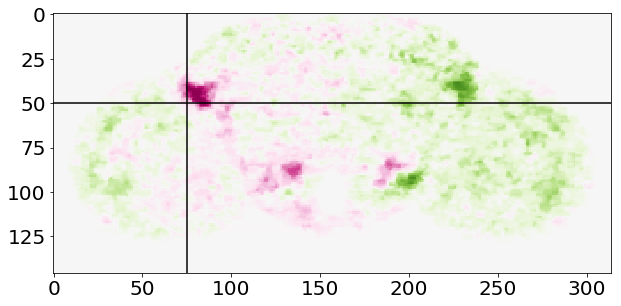

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(diff_map[:,:,63].T,cmap='PiYG',vmin=-.1,vmax=.1)
plt.axhline(50,color='k')
plt.axvline(75,color='k')

In [38]:
import matplotlib

In [44]:
cmap = matplotlib.cm.get_cmap('cet_gwv')

In [40]:
cmap.set_under('k')
cmap.set_bad('w')


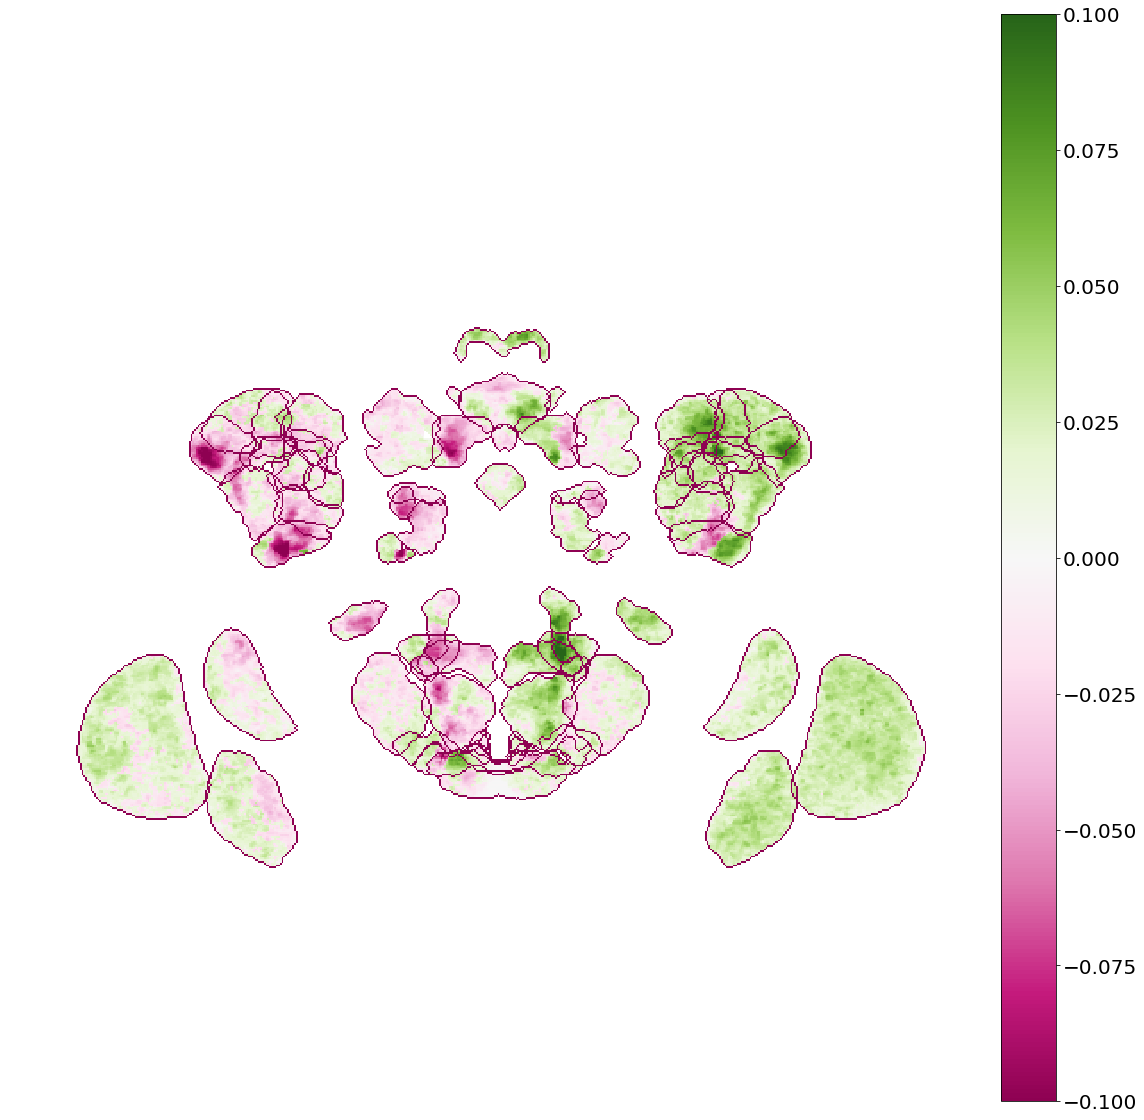

In [57]:
plt.figure(figsize=(20,20))
plt.imshow(canvas[150:,:],cmap='PiYG',vmin=-.1,vmax=.1)
plt.colorbar()
plt.axis('off')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [28]:
import colorcet as cc

In [106]:
all_colored_by_betas['fwd'].shape
#256, 128, 49

(49, 256, 128)

In [ ]:
np.roll(all_colored_by_betas['fwd']).shape


(-0.5, 255.5, 127.5, -0.5)

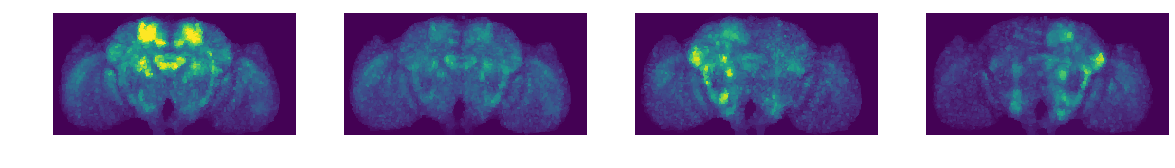

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(np.max(all_colored_by_betas['fwd'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(np.max(all_colored_by_betas['fwd_slow'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(np.max(all_colored_by_betas['rot_pos'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(np.max(all_colored_by_betas['rot_neg'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

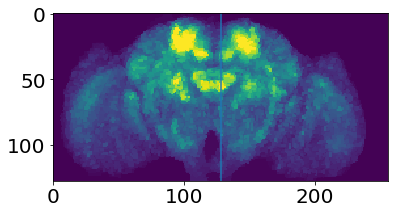

In [102]:
plt.imshow(np.max(all_colored_by_betas['fwd'],axis=0).T,vmin=0,vmax=.2)
plt.axvline(128)

In [97]:
diff_map1 = all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_pos']
diff_map2 = (all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_neg'])
diff_map2 = diff_map2[:,::-1,:]
diff_map = (diff_map1+diff_map2)/2
diff_map.shape

(49, 256, 128)

In [98]:
maxs = np.max(diff_map,axis=0)
mins = np.min(diff_map,axis=0)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

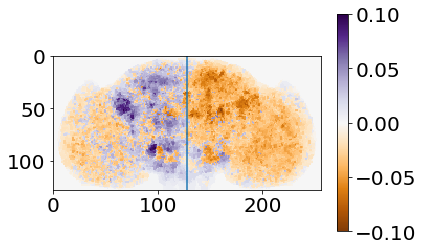

In [100]:
plt.imshow(maxs.T*-1,cmap='PuOr',vmin=-.1,vmax=.1)
plt.axvline(128)
plt.colorbar()

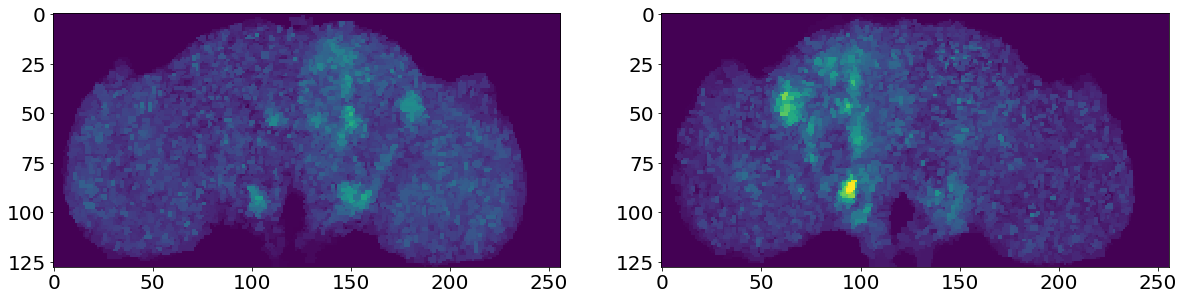

In [36]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.max(all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_pos'],axis=0).T,vmin=0,vmax=.2)
plt.subplot(1,2,2)
plt.imshow(np.max((all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_pos'])*-1,axis=0).T,vmin=0,vmax=.2)


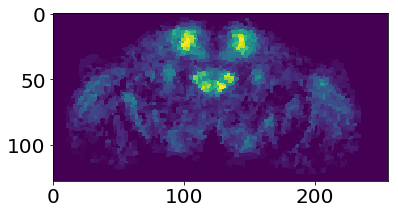

In [33]:
plt.imshow(all_colored_by_betas['fwd'][20,:,:].T,vmin=0,vmax=.2)

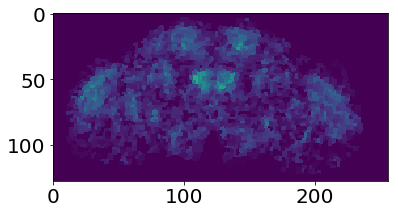

In [32]:
plt.imshow(all_colored_by_betas['fwd_slow'][20,:,:].T,vmin=0,vmax=.2)

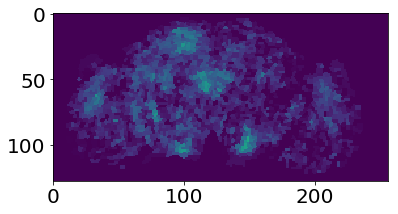

In [34]:
plt.imshow(all_colored_by_betas['rot_pos'][20,:,:].T,vmin=0,vmax=.2)

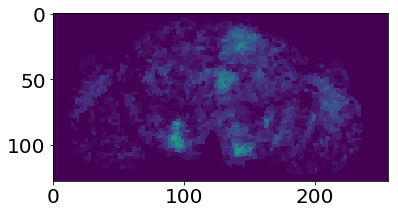

In [35]:
plt.imshow(all_colored_by_betas['rot_neg'][20,:,:].T,vmin=0,vmax=.2)

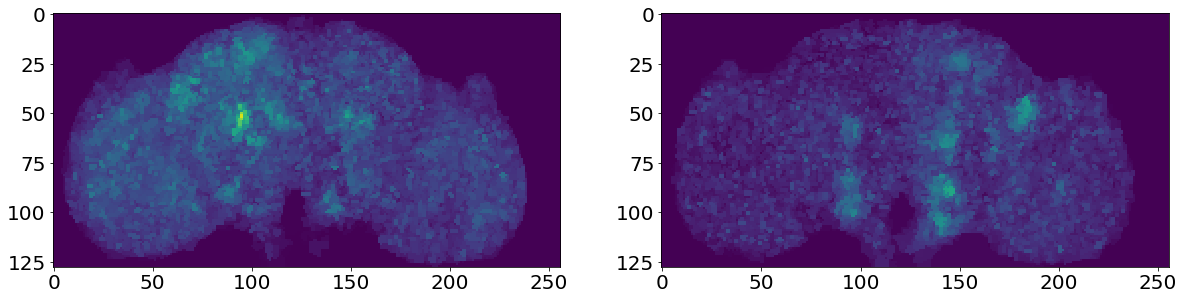

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.max(all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_neg'],axis=0).T,vmin=0,vmax=.2)
plt.subplot(1,2,2)
plt.imshow(np.max((all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_neg'])*-1,axis=0).T,vmin=0,vmax=.2)


# Draw bounding boxes on 2d behavior hist

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [3]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [4]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [5]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 58.80 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.31 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 55.12 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.88 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 58.09 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.42 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 61.41 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.21 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 65.47 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.35 sec
*** fly: f

In [6]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [7]:
YZ = np.sqrt(np.power(behavior_super['Y_std'],2), np.power(behavior_super['Z_std'],2))

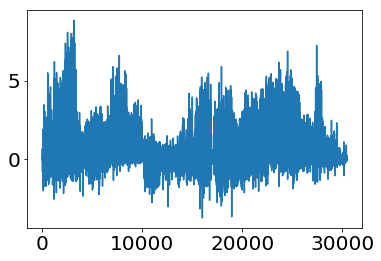

In [132]:
plt.plot(behavior_super['Y_std'])

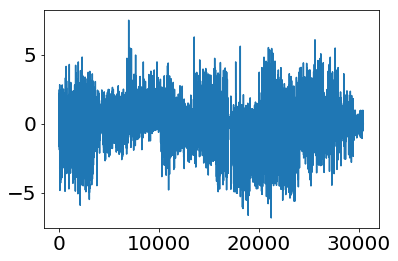

In [133]:
plt.plot(behavior_super['Z_std'])

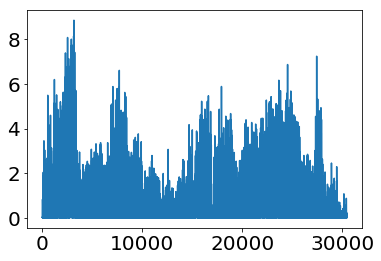

In [131]:
plt.plot(YZ)

In [124]:
np.std(behavior_super['Y'])

0.010789193260969974

In [126]:
np.std(behavior_super['Z'])

0.027563803888671537

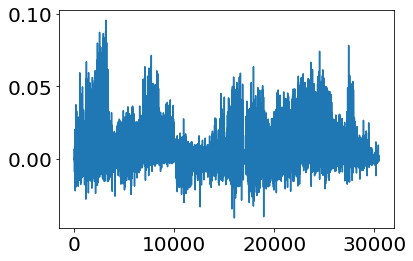

In [123]:
plt.plot(behavior_super['Y'])

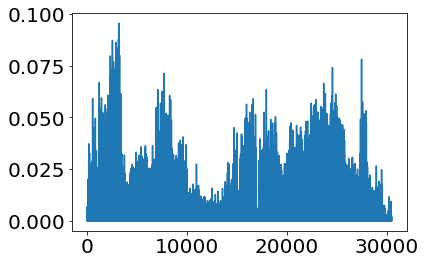

In [120]:
plt.plot(fwd[20,:])

In [8]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    #bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
    #bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))
    
#     bins_x = [x / 10.0 for x in range(-20, 64, 4)]
#     bins_y = [x / 10.0 for x in range(-40, 44, 4)]
#     num_bins_x = 22
#     num_bins_y = 22
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    #test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], test['pc_count'], bins_x, bins_y

In [9]:
from matplotlib.colors import LogNorm

In [10]:
from matplotlib import colors
import matplotlib.patches as patches


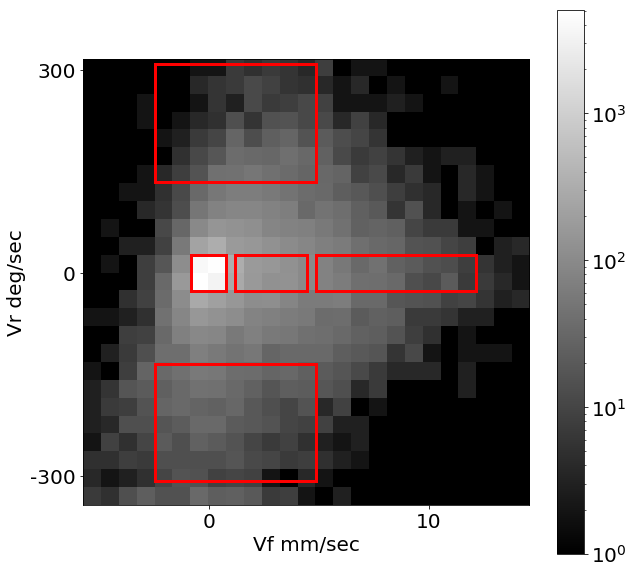

In [11]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

signal = np.ones(30456)#fwd_resp#temporal[:,k]
#plt.subplot(5,5,k+1)
fictrac_2d, bin_cnt, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

bin_cnt[np.where(bin_cnt==0)]=1
plt.imshow(bin_cnt,cmap='gray',extent=[-2.35,6,-4.35,4],norm=colors.LogNorm()) #.2
plt.colorbar()
#plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

ax = plt.gca()

rect = patches.Rectangle((-1/3, -1/3), 2/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((0.5, -1/3), 1+1/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((2, -1/3), 3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((-1, 1.7), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((-1, -3.9), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
ax.set_yticklabels([-300, 0, 300])
ax.set_yticks([-300*ratio, 0, 300*ratio])

ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
ax.set_xticklabels([0, 10])
ax.set_xticks([0, 10*ratio])

plt.ylabel('Vr deg/sec')
plt.xlabel('Vf mm/sec')

#plt.colorbar()

#ax.axhline(0,linestyle='--',color='k',linewidth=1)
#ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

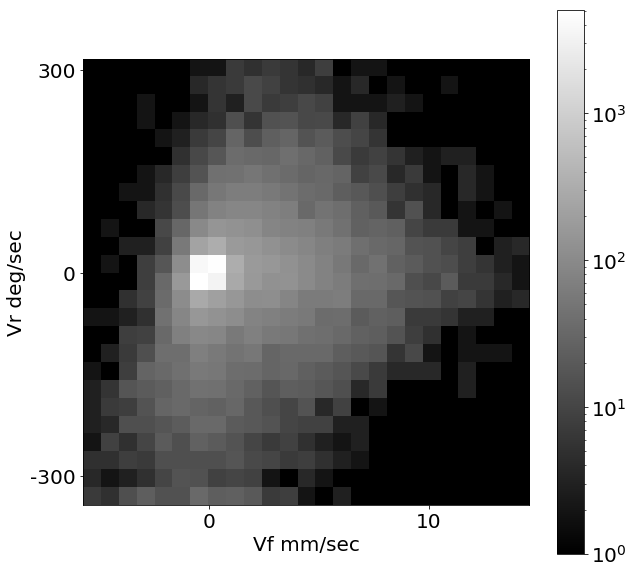

In [13]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

signal = np.ones(30456)#fwd_resp#temporal[:,k]
#plt.subplot(5,5,k+1)
fictrac_2d, bin_cnt, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

bin_cnt[np.where(bin_cnt==0)]=1
plt.imshow(bin_cnt,cmap='gray',extent=[-2.35,6,-4.35,4],norm=colors.LogNorm()) #.2
plt.colorbar()
#plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

ax = plt.gca()

# rect = patches.Rectangle((-1/3, -1/3), 2/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((0.5, -1/3), 1+1/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((2, -1/3), 3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((-1, 1.7), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((-1, -3.9), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
ax.set_yticklabels([-300, 0, 300])
ax.set_yticks([-300*ratio, 0, 300*ratio])

ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
ax.set_xticklabels([0, 10])
ax.set_xticks([0, 10*ratio])

plt.ylabel('Vr deg/sec')
plt.xlabel('Vf mm/sec')

#plt.colorbar()

#ax.axhline(0,linestyle='--',color='k',linewidth=1)
#ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight', transparent=True)

In [230]:
### these thresh match the boxes above ###

mean_signals = {}

f = behavior_super['Y_std']
r = behavior_super['Z_std']

signals_stop = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > -1/3) & (f < 1/3) & (r < 1/3) & (r > -1/3))][0,:,:],axis=0)
    signals_stop.append(signal)
mean_signals['stop'] = np.asarray(signals_stop)

signals_fwd = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > 2) & (f < 5) & (r < 1/3) & (r > -1/3))][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd'] = np.asarray(signals_fwd)

signals_rot_pos = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > -1) & (f < 3) & (r > 1.7) & (r < 5))][0,:,:],axis=0)
    signals_rot_pos.append(signal)
mean_signals['rot_pos'] = np.asarray(signals_rot_pos)

signals_rot_neg = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > -1) & (f < 3) & (r > -5) & (r < -1.7))][0,:,:],axis=0)
    signals_rot_neg.append(signal)
mean_signals['rot_neg'] = np.asarray(signals_rot_neg)

signals_fwd = []
for z in range(49):
    idx = np.where((f > 0.5) & (f < 1.5+1/3) & (r < 1/3) & (r > -1/3))
    signal = np.mean(X_all_neural_z_vox_t[z,:,idx][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd_slow'] = np.asarray(signals_fwd)

In [231]:
all_colored_by_betas = {}
for beh in ['stop', 'fwd', 'fwd_slow', 'rot_pos' ,'rot_neg']:
    all_colored_by_betas[beh] = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = mean_signals[beh][z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas[beh].append(colored_by_betas)
    all_colored_by_betas[beh] = np.asarray(all_colored_by_betas[beh])
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],0,1)
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],1,2)

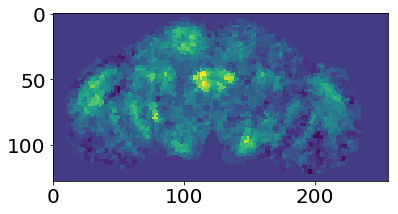

In [208]:
plt.imshow(all_colored_by_betas['rot_pos'][:,:,20].T)

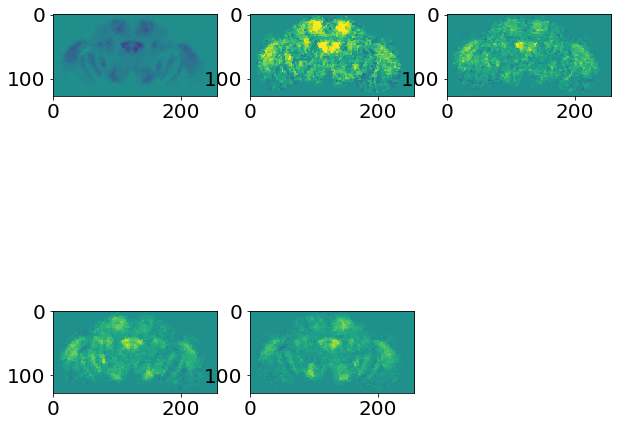

In [209]:
plt.figure(figsize=(10,10))
for i,beh in enumerate(['stop', 'fwd', 'fwd_slow', 'rot_pos' ,'rot_neg']):
    plt.subplot(2,3,i+1)
    plt.imshow(all_colored_by_betas[beh][:,:,20].T,vmin=-.1,vmax=.1)

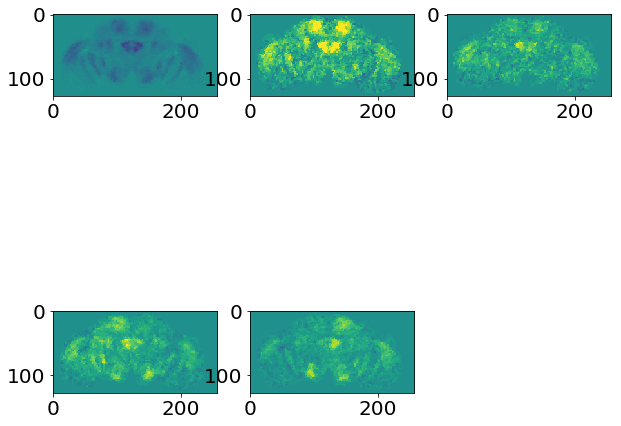

In [196]:
plt.figure(figsize=(10,10))
for i,beh in enumerate(['stop', 'fwd', 'fwd_slow', 'rot_pos' ,'rot_neg']):
    plt.subplot(2,3,i+1)
    plt.imshow(all_colored_by_betas[beh][:,:,20].T,vmin=-.1,vmax=.1)

In [232]:
res_LUKE = (2.6076, 2.6154, 5.3125)
maps_voxel_res = {}
for beh in ['stop', 'fwd', 'rot_pos', 'rot_neg', 'fwd_slow']:
    moving = ants.from_numpy(all_colored_by_betas[beh][:,:,::-1])
    moving.set_spacing(res_LUKE)
    maps_voxel_res[beh] = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0])

In [233]:
diff_map1 = maps_voxel_res['fwd_slow']-maps_voxel_res['rot_pos']
diff_map2 = (maps_voxel_res['fwd_slow']-maps_voxel_res['rot_neg'])
diff_map2 = diff_map2[::-1,:,:]
diff_map = (diff_map1+diff_map2)/2

In [241]:
diff_map = maps_voxel_res['fwd']-maps_voxel_res['fwd_slow']

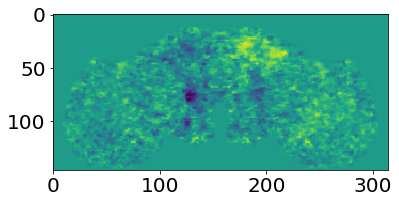

In [212]:
plt.imshow(diff_map[:,:,40].T)

In [127]:
# for walking vectors, I picked 0.2 as thresh. This unit is in std of a joint fwd rot vector
# simplify to assume 0.2 fwd std thresh

45.0

In [116]:
# If I pick a fwd value of 5mm/sec, I can find the edge of the box with
unit_value = 5
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
unit_value*ratio

# conversely, if I want to get the real unit value from a threshold
thresh_value = 1/3
thresh_value/ratio

0.8091894945727479

In [117]:
unit_value = 1
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
unit_value*ratio

0.41193482561131534

In [138]:
# lets make our thresholds in std space, so they can be easily compared between fwd and turn

stopped_thresh = 1/3 #std
# what is this in unit space?
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
print(stopped_thresh/ratio)
ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
print(stopped_thresh/ratio)


0.8091894945727479
26.321493835786086


In [135]:
4/ratio

9.710273934872976